# Imports


In [1]:
#Data loading 
import torch
from torch.utils import data
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#model 
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

# Creating dataloaders
Source : https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

## Definie the data encoder the data

In [2]:
#Data encoder 
def sparse_encode(seq, rna_dict):
    """For a given nucleotide sequence, return a sequence with each nucleotide encoded as a one hot vector"""
    enc_seq = np.zeros([len(seq),len(RNA_DICT)])
    for i, nuc in enumerate(seq):
        enc_seq[i, rna_dict[nuc]] = 1
    return enc_seq

def encode_with_padding(seq, max_len, rna_dict):
    seq_onehot = np.zeros([max_len, len(RNA_DICT)], dtype=np.uint8)
    length = len(seq)
    encoded_seq = sparse_encode(seq, rna_dict)
    seq_onehot[:length,:] = encoded_seq
    seq_onehot[length:,5:6] = 1
    return(seq_onehot)



## Load and encode the data

In [3]:
VAL = "data/val_filtered.txt"
TRAIN = "data/train_filtered.txt"
TEST = "data/test_filtered.txt"

RNA_DICT = {'A': 0, 'T': 1, 'C': 2, 'G': 3, 'N': 4, '-': 5}
partition = {'train':[], 'validation':[], 'test':[]} #lists containing ids of the sequences 
labels = {} # {seq_id : class}
sequences = {} # {seq_id : encoded_seq}
index = 0
max_len = 0

with open(VAL, 'r') as fIn : 
    for line in fIn : 
        #manage seq id 
        seq_id = "id_"+str(index)
        index +=1
        #read line in file 
        seq = line.replace(" ", "").strip().split(",")
        
        #search for max seq len
        max_len = len(seq[0]) if len(seq[0])>max_len else max_len
        #encode sequence
        #encod_seq = sparse_encode(seq[0], RNA_DICT)
        #store data
        partition['validation'].append(seq_id)
        labels[seq_id]=int(seq[1])
        sequences[seq_id] = seq[0]


with open(TRAIN, 'r') as fIn : 
    for line in fIn : 
        #manage seq id 
        seq_id = "id_"+str(index)
        index +=1
        #read line in file 
        seq = line.replace(" ", "").strip().split(",")
        max_len = len(seq[0]) if len(seq[0])>max_len else max_len
        #encode sequence
        #encod_seq = sparse_encode(seq[0], RNA_DICT)
        #store data
        partition['train'].append(seq_id)
        labels[seq_id]=int(seq[1])
        sequences[seq_id] = seq[0]
        
        
with open(TEST, 'r') as fIn : 
    for line in fIn : 
        #manage seq id 
        seq_id = "id_"+str(index)
        index +=1
        #read line in file 
        seq = line.replace(" ", "").strip().split(",")
        max_len = len(seq[0]) if len(seq[0])>max_len else max_len
        #encode sequence
        #encod_seq = sparse_encode(seq[0], RNA_DICT)
        #store data
        partition['test'].append(seq_id)
        labels[seq_id]=int(seq[1])
        sequences[seq_id] = seq[0]

for seq_id, seq in sequences.items():
    sequences[seq_id] = encode_with_padding(seq, max_len, RNA_DICT)

list_IDs = partition['train'] + partition['validation'] + partition['test']


## Define the dataset class

In [4]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, list_IDs, labels, sequences):
        """Initialization"""
        self.labels = labels
        self.list_IDs = list_IDs
        self.sequences = sequences
           
    def __len__(self):
        """Denotes the total number of samples"""
        return len(self.list_IDs)

    def __getitem__(self, index):
        """Generates one sample of data"""
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = self.sequences[ID]
        Y = self.labels[ID]

        return X, Y

## Create training and validation Dataloader

In [5]:
# CUDA for PyTorch
#use_cuda = torch.cuda.is_available()
use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")

# Parameters
params = {'batch_size': 30,
          'shuffle': True,
          'num_workers': 0}

params_valid = {'batch_size': 100,
          'shuffle': True,
          'num_workers': 0}
max_epochs = 100

training_set = Dataset(partition['train'], labels, sequences)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'], labels, sequences)
validation_generator = data.DataLoader(validation_set, **params_valid)

test_set = Dataset(partition['test'], labels, sequences)
test_generator = data.DataLoader(validation_set, **params)

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()


# Build the model

In [7]:
# CNN
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

#functions to compute the dimemensions of the output of conv layers
def compute_conv1_dim(dim_size):
    return int(((dim_size - kernel_size_conv1 + 2 * padding_conv1) / (stride_conv1) + 1))

channels = 1
input_len = max_len
input_width = 6
num_filters_conv1 = 6
kernel_size_conv1 = 6 
padding_conv1 = 0
stride_conv1 = 1

num_l1 = 256
num_l2 = 128

num_classes = 6

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=channels,
                              out_channels = num_filters_conv1,
                              kernel_size = kernel_size_conv1)
        
        #self.maxpool = nn.MaxPool2d(2, stride = 2)
        
        self.out_conv1_len = compute_conv1_dim(input_len)#//2
        self.out_conv1_width = compute_conv1_dim(input_width)#//2
        
        self.fc1 = nn.Linear(kernel_size_conv1 * self.out_conv1_len * self.out_conv1_width, num_l1) 
        #the first input is filter_size*heigth*width
        
        self.fc2 = nn.Linear(num_l1,num_l2)
        
        self.fc3 = nn.Linear(num_l2, num_classes)
        
    def forward(self, x):
        x = torch.from_numpy(np.expand_dims(x, axis=1))
        x = F.relu(self.conv1(x))
        x = x.view(-1,num_filters_conv1 * self.out_conv1_width * self.out_conv1_len)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net(num_classes)

print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features=115968, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)


# Build the cost function

In [8]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

# Test network

In [9]:
#Test the forward pass with dummy data

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

x = Variable(torch.from_numpy(randnorm((params["batch_size"],max_len, 6))))
#x = get_variable(x)
print(x.shape)
net(x)

torch.Size([30, 19333, 6])


tensor([[-0.0612,  0.1195,  0.0446, -0.0286, -0.0525,  0.1182],
        [-0.0631,  0.0784, -0.0099, -0.0454, -0.0550,  0.0847],
        [-0.0622,  0.0890,  0.0335, -0.0048, -0.0816,  0.0947],
        [-0.0556,  0.1366,  0.0114, -0.0389, -0.0629,  0.0933],
        [-0.0743,  0.1454, -0.0388, -0.0316, -0.0801,  0.0959],
        [-0.0758,  0.0978, -0.0116, -0.0100, -0.0691,  0.1067],
        [-0.0554,  0.1331,  0.0092, -0.0481, -0.1001,  0.1355],
        [-0.0975,  0.0863,  0.0309, -0.0088, -0.0380,  0.0673],
        [-0.1358,  0.1105, -0.0154,  0.0068, -0.0594,  0.0828],
        [-0.0798,  0.0649, -0.0161,  0.0216, -0.0555,  0.0924],
        [-0.0245,  0.0636,  0.0372, -0.0156, -0.0583,  0.0299],
        [-0.0864,  0.1206,  0.0043, -0.0011, -0.0012,  0.0955],
        [-0.0635,  0.1043,  0.0181, -0.0208, -0.0303,  0.0451],
        [-0.0934,  0.0822, -0.0207, -0.0370, -0.0440,  0.0804],
        [-0.0907,  0.0663,  0.0526, -0.0245, -0.0669,  0.1001],
        [-0.1491,  0.1429, -0.0661, -0.0

# Train the network

/home/allenwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


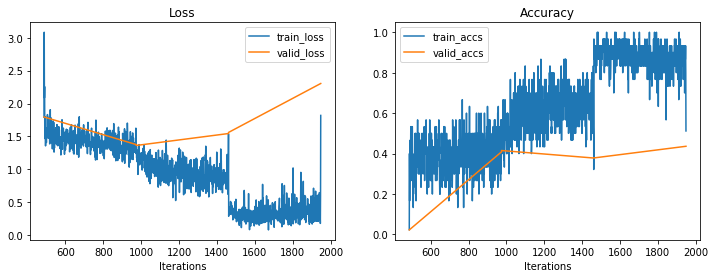

Finished Training


In [10]:
num_epoch = 3
iter_by_epoch = len(training_generator.dataset.list_IDs)/training_generator.batch_size 
eval_every = int(iter_by_epoch) #eval one time by epoch 
train_loss, train_accs = [], []
valid_loss, valid_accs = [], []
valid_iter = []
train_iter = []

def get_input_and_label(batch):
    inputs, labels = batch[0], batch[1] 
    # Change type
    inputs = inputs.type(torch.float)
    labels = labels.type(torch.long)
    # Transfer to GPU
    inputs, labels = inputs.to(device), labels.to(device)
    return(inputs, labels)

iter_by_epoch = len(training_generator.dataset.list_IDs)/training_generator.batch_size


for epoch in range(num_epoch):
    running_loss = 0.0
    net.train()
    # Training
    for i, data in enumerate(training_generator,0):

        if i % eval_every == 0:
            valid_iter.append(i + (1+epoch)*iter_by_epoch)
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
            
            for num, data in enumerate(validation_generator,0):
                inputs, labels = get_input_and_label(data)
                output = net(inputs)
                val_losses += criterion(output, labels) * num
                val_accs += accuracy(output, labels) * num
                val_lengths += num

            # divide by the total accumulated batch sizes
            val_losses /= val_lengths
            val_accs /= val_lengths
            valid_loss.append(get_numpy(val_losses))
            valid_accs.append(get_numpy(val_accs))
            net.train()
        inputs, labels = get_input_and_label(data) 

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]

        train_loss.append(get_numpy(loss))
        train_accs.append(get_numpy(accuracy(outputs, labels)))
        train_iter.append(i + (epoch+1)*iter_by_epoch)


fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(train_iter, train_loss, label='train_loss')
plt.plot(valid_iter, valid_loss, label='valid_loss')
plt.xlabel('Iterations')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter, train_accs, label='train_accs')
plt.plot(valid_iter, valid_accs, label='valid_accs')
plt.xlabel('Iterations')
plt.title('Accuracy')
plt.legend()
plt.show()

print('Finished Training')